## Описание проекта  
Проведу исследование рынка комрьютерных игр. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

Передо мной данные до 2016 года, сейчас декабрь 2016 г., и я планирую кампанию на 2017-й. Нужно отработать принцип работы с данными.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».  

**Мне нужно** выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Шаг 1. Открою файл с данными и изучите общую информацию

Импортирую необходимые библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from matplotlib import pyplot as plt
from math import factorial
from scipy import stats as st
import seaborn as sns

Уберу предупреждения питона

In [2]:
import warnings
warnings.filterwarnings("ignore")

Включу вывод всего из ячейки

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Прочитаю файл и оценю общие сведения о данных

In [4]:
df = pd.read_csv('games.csv')

In [5]:
df.shape

(16715, 11)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [7]:
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

## Шаг 2. Подготовлю данные

### Заменю названия столбцов;

Переименую столбцы, чтобы названия были простыми и понятными, содержали только строчные буквы (нужного регистра)

In [8]:
column_names = ['name', 'platform', 'year', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']
df.set_axis(column_names, axis='columns', inplace=True)

### Преобразую данные в нужные типы. Опишу, в каких столбцах заменили тип данных и почему

Посмотрю на уникальные значения в столбцах с дискретными данным

In [9]:
for name in ['name', 'platform', 'year', 'genre']:
    print('Уникальные значения в столбце',  name, '\n', df[name].unique())

Уникальные значения в столбце name 
 ['Wii Sports' 'Super Mario Bros.' 'Mario Kart Wii' ...
 'Woody Woodpecker in Crazy Castle 5' 'LMA Manager 2007'
 'Haitaka no Psychedelica']
Уникальные значения в столбце platform 
 ['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4' '3DS' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'WiiU' 'GC' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']
Уникальные значения в столбце year 
 [2006. 1985. 2008. 2009. 1996. 1989. 1984. 2005. 1999. 2007. 2010. 2013.
 2004. 1990. 1988. 2002. 2001. 2011. 1998. 2015. 2012. 2014. 1992. 1997.
 1993. 1994. 1982. 2016. 2003. 1986. 2000.   nan 1995. 1991. 1981. 1987.
 1980. 1983.]
Уникальные значения в столбце genre 
 ['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy' nan]


Чтобы преобразовать тип столбца с годом из float в int необходимо заполнить пропуски.  
Сгруппирую данные по названиям игр и вычислю медианный год релиза для заполнения пропусков.

In [10]:
name_year = df.groupby('name')['year'].median().reset_index()

Без года релиза немного строк, но мы можем заполнить некоторые данные на основании медианных дианных по другим платформам, т.к. игры выходят примерно одновременно на разных.

In [11]:
df['year'] = df['year'].fillna(df.groupby('name')['year'].transform('median'))
count_wo_year = df['year'].isna().sum()
print('Без указания года релиза после заполнения по медиане: {:.1%} строк'.format(count_wo_year / len(df)))

Без указания года релиза после заполнения по медиане: 0.9% строк


Удалю оставшиеся строки без года релиза, т.к. их немного:

In [12]:
df.dropna(subset = ['year'], inplace = True)
df['year'].isna().sum() # оставшиеся значения 'year' с пропусками

0

Преобразую годы в тип "integer":

In [13]:
df.loc[df['year'].isna() == False, 'year'] = df.loc[df['year'].isna() == False, 'year'].astype(int)

Оба столбца с рейтингами имеют тип "object", что выглядит не логичным

In [14]:
df[['user_score', 'rating']].head()

,user_score,rating
0,8,E
1,NaN,NaN
2,8.3,E
3,8,E
4,NaN,NaN


In [15]:
unique_score = df['user_score'].value_counts().rename_axis('unique_values').reset_index(name='counts')
unique_rating = df['rating'].value_counts().rename_axis('unique_values').reset_index(name='counts')

Выведу все варианты уникальных значений:

In [16]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(unique_score)
    print(unique_rating)

   unique_values  counts
0            tbd    2394
1            7.8     324
2              8     288
3            8.2     279
4            8.3     253
5            8.5     252
6            7.5     251
7            7.9     249
8            8.1     241
9            7.7     239
10           7.3     236
11           8.4     222
12             7     219
13           7.4     215
14           7.6     214
15           8.6     209
16           6.8     195
17           8.7     187
18           8.8     182
19           7.1     180
20           7.2     166
21           8.9     151
22           6.6     148
23           6.9     140
24           6.3     136
25           6.7     128
26             6     127
27           6.5     125
28             9     119
29           6.2     113
30           6.4     106
31           5.8      97
32           9.1      90
33           6.1      82
34           5.9      77
35           5.7      77
36           5.4      72
37           5.6      72
38           5.5      70


In [17]:
print('Пропущенных значений в "user_score":{:.0f}. Это {:.0%} от всех данных.'.format(df['user_score'].isna().sum(), df['user_score'].isna().sum() / len(df)))
print('Пропущенных значений в "rating":{:.0f}. Это {:.0%} от всех данных.'.format(df['rating'].isna().sum(), df['rating'].isna().sum() / len(df)))

Пропущенных значений в "user_score":6635. Это 40% от всех данных.
Пропущенных значений в "rating":6701. Это 40% от всех данных.


У нас есть очень много уникальных значений "tbd". Предположу, что это "To Be Determined". С этим ничего не поделать, видимо.  
Кроме этого, есть пропущенные значения в 'user_score' (40%) и 'rating' (40%).

Заменю загадочные 'tbd' на пропуски:

In [18]:
df['user_score'] = df['user_score'].replace('tbd', None)

Переведу 'user_score' в тип 'float'

In [19]:
df['user_score'] = df['user_score'].astype(float)

Заменю значения в старом названии "K-A" ("Kins to Asults") на актуальное "E" ("Everyone")

In [20]:
df['rating'] = df['rating'].replace('K-A', 'E')

In [21]:
df['rating'] = df['rating'].fillna('no_rating')

### Обработаю пропуски при необходимости

Посмотрю, в каких столбцах есть пропущенные значения

In [22]:
df.isna().sum()

name               2
platform           0
year               0
genre              2
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score    8494
user_score      7871
rating             0
dtype: int64

In [23]:
df[df['genre'].isna()]

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,no_rating
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,no_rating


Нет данных, по которым можно было бы заполнить пропуски. Удалю строки эти строки.

In [24]:
df[df['name'].isna()]

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,no_rating
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,no_rating


Тоже не достаточно данных для заполнения пропусков. Удаляю.

In [25]:
df.dropna(subset = ['name', 'genre'], inplace = True)

Значение tbd в столбце с рейтингом по консолидированному мнению походе на 'to be determined'. Я обработал их ранее.

### Посчитаю суммарные продажи во всех регионах и запишу их в отдельный столбец

In [26]:
df.columns

Index(['name', 'platform', 'year', 'genre', 'na_sales', 'eu_sales', 'jp_sales',
       'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Запишу суммарные продажи в новый столбец

In [27]:
df['ttl_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

## Шаг 3. Проведу исследовательский анализ данных

### Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

Сгруппируюю данные по годам и посчитаю кол-во выпущенных игр

Text(0.5, 1.0, 'count of games by years')

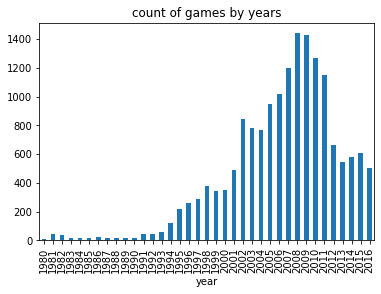

In [28]:
games_years = df.groupby('year')['name'].count()
plt.title('count of games by years')
games_years.plot.bar()

Оценю распределение выпущенных игр по годам на "ящике с усами"

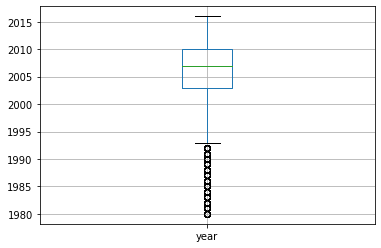

count    16567.000000
mean      2006.490252
std          5.862680
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year, dtype: float64

In [29]:
df.boxplot(column = 'year')
plt.show()
df['year'].describe()

Похоже, данные до 1993 года оказывают несущественное влияние на общую картину — игры тогда только зарождались в современном понимании.  
Удалять не буду, пока это не влияем на анализ. Посмотрю на всякий случай, как распределены продажи по годам.

Text(0.5, 1.0, 'ttl sales value by years')

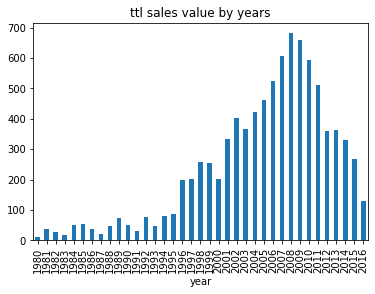

In [30]:
df.groupby('year')['ttl_sales'].sum().plot.bar()
plt.title('ttl sales value by years')
plt.show()

Распределение объёмов общих продаж по годам имеет похожее распределение на выпуск игр.

### Посмотрю, как менялись продажи по платформам. Выберу платформы с наибольшими суммарными продажами и построю распределение по годам. Оценю, за какой характерный срок появляются новые и исчезают старые платформы?

Посмотрю на продажи по платформам, отсортированные по возрастанию

In [31]:
pl_sales = df.groupby('platform')['ttl_sales'].sum().reset_index().sort_values(by = 'ttl_sales', ascending = False)
pl_sales

,platform,ttl_sales
16,PS2,1247.16
28,X360,966.61
17,PS3,935.19
26,Wii,903.31
4,DS,804.28
15,PS,727.58
18,PS4,314.14
6,GBA,313.73
19,PSP,293.57
13,PC,258.86


Возьму топ-5 платформ по продажам и построю по ним распределение

Text(0.5, 1.0, 'PS2')

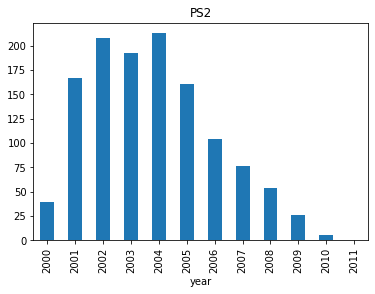

Text(0.5, 1.0, 'X360')

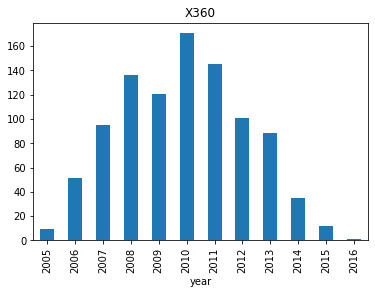

Text(0.5, 1.0, 'PS3')

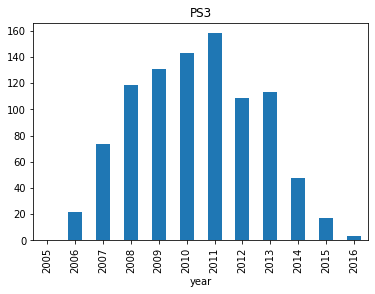

Text(0.5, 1.0, 'Wii')

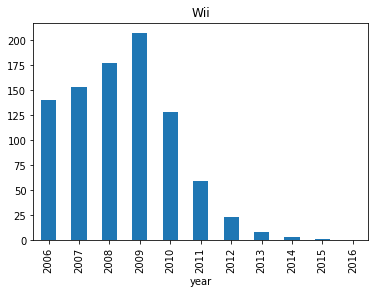

Text(0.5, 1.0, 'DS')

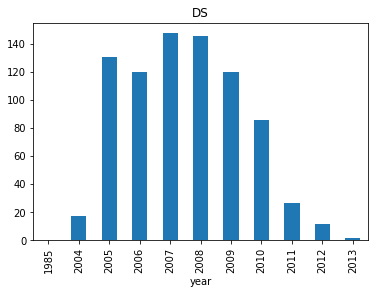

In [32]:
pl_sales_top = pl_sales.head(5)
for i in pl_sales_top['platform']:
    df[df['platform'] == i].groupby('year')['ttl_sales'].sum().plot.bar()
    plt.title(i)
    plt.show()

Похоже, что проходит около 9 лет, за которые платформа теряет популярность. После этого ей нужна замена, чтобы поддерживать пользовательский интерес к серии.

### Возьму данные за соответствующий актуальный период. Актуальный период определил в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.
Не учитываю в работе данные за предыдущие годы

Возьму данные с 1993 года, по ранним расчётам с этого времени выпущено достаточное кол-во игр, чтобы строит анализ.

In [33]:
df_new = df[df['year'] >= 2003]

Далее буду анализировать датафрейм df_new

### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ

Посчитаю суммарные продажи по платформам

In [34]:
high_po = df_new.groupby(['platform', 'year'])['ttl_sales'].sum().reset_index()

Выберу топ-5 среди отсортированных платформ

In [35]:
high_po_top = high_po.groupby('platform')['ttl_sales'].sum().reset_index().sort_values(
    by = 'ttl_sales', ascending = False).reset_index().head(5)
print('По продажам лидируют:')
print(high_po_top)

По продажам лидируют:
   index platform  ttl_sales
0     15     X360     966.61
1      9      PS3     935.19
2     13      Wii     903.31
3      8      PS2     833.20
4      2       DS     804.26


In [36]:
high_po['platform'].unique()

array(['3DS', 'DC', 'DS', 'GBA', 'GC', 'N64', 'PC', 'PS', 'PS2', 'PS3',
       'PS4', 'PSP', 'PSV', 'Wii', 'WiiU', 'X360', 'XB', 'XOne'],
      dtype=object)

Посмотрю на динамику по годам по каждой платформе

In [37]:
high_po

,platform,year,ttl_sales
0,3DS,2010,0.30
1,3DS,2011,63.20
2,3DS,2012,51.76
3,3DS,2013,56.57
4,3DS,2014,43.76
...,...,...,...
121,XB,2008,0.18
122,XOne,2013,18.96
123,XOne,2014,54.07
124,XOne,2015,60.14


Отключу вывод всего из ячеек

In [38]:
InteractiveShell.ast_node_interactivity = "last_expr"

Построю диаграммы продаж по каждой платформе и по годам

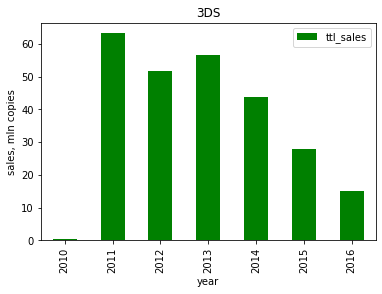

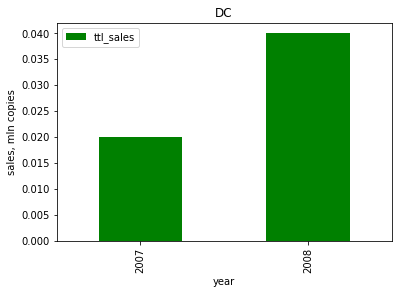

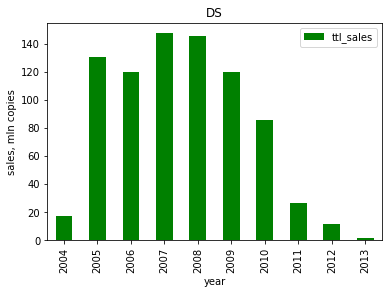

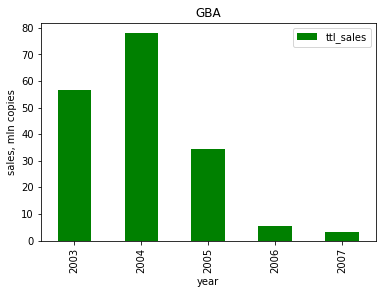

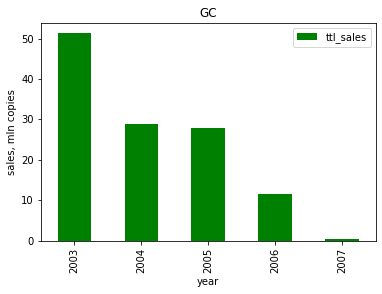

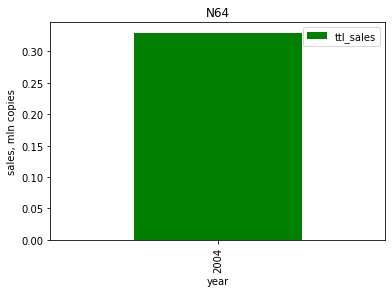

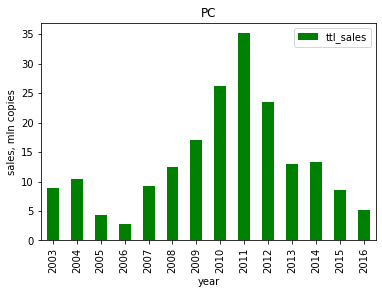

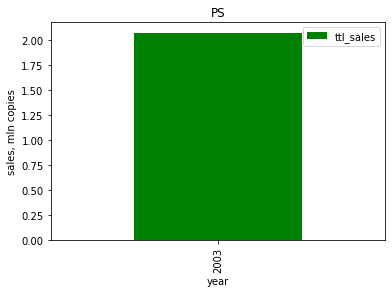

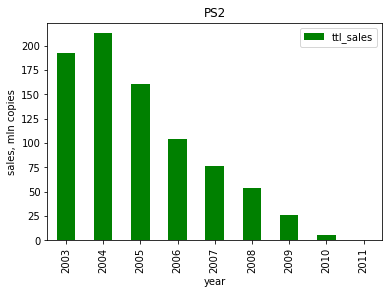

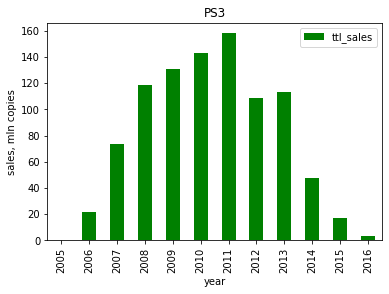

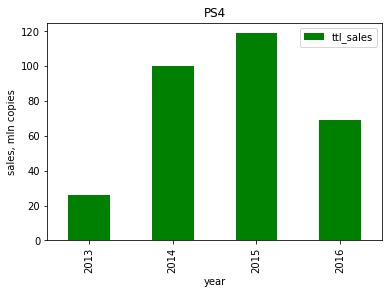

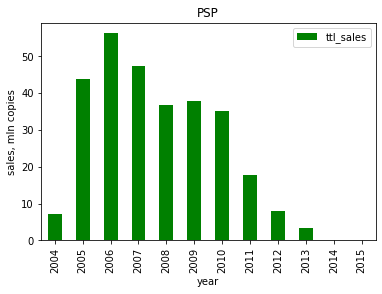

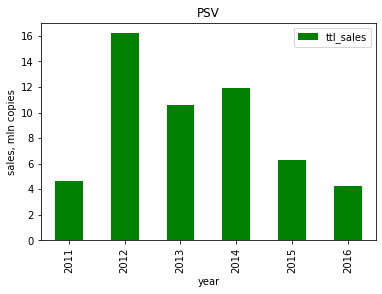

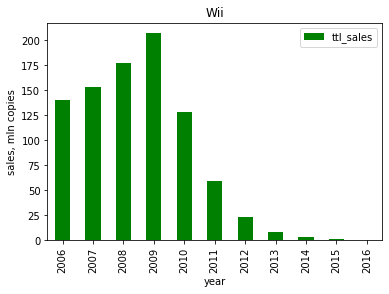

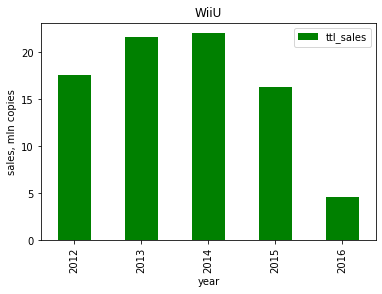

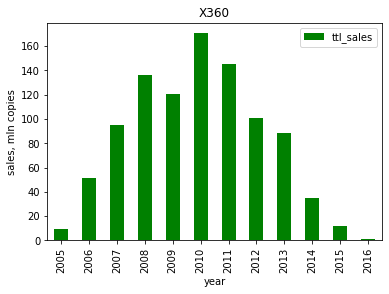

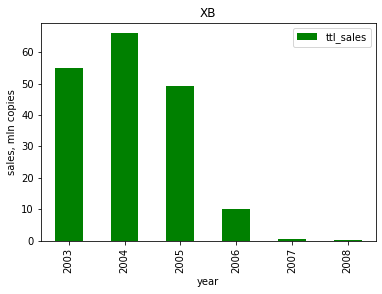

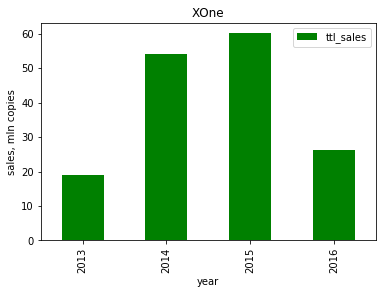

In [39]:
for i in high_po['platform'].unique():
    high_po[high_po['platform'] == i].plot(kind='bar', x='year', y='ttl_sales', color='green')
    plt.title(i)
    plt.ylabel('sales, mln copies')

Судя по динамике, надежда на рост есть у платформы РС и PS4. При этом очевидно, что PS4 в течение нескольких лет будет заменены на обновлённую консоль.

### Построю график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

In [40]:
print('Всего в df {:.0f} платформ.'.format(len(df['platform'].unique())))
print('Всего в df_new {:.0f} отобранных платформ.'.format(len(df_new['platform'].unique())))
print('В списке hifh_po {:.0f} платформ.'.format(len(high_po['platform'].unique())))

Всего в df 31 платформ.
Всего в df_new 18 отобранных платформ.
В списке hifh_po 18 платформ.


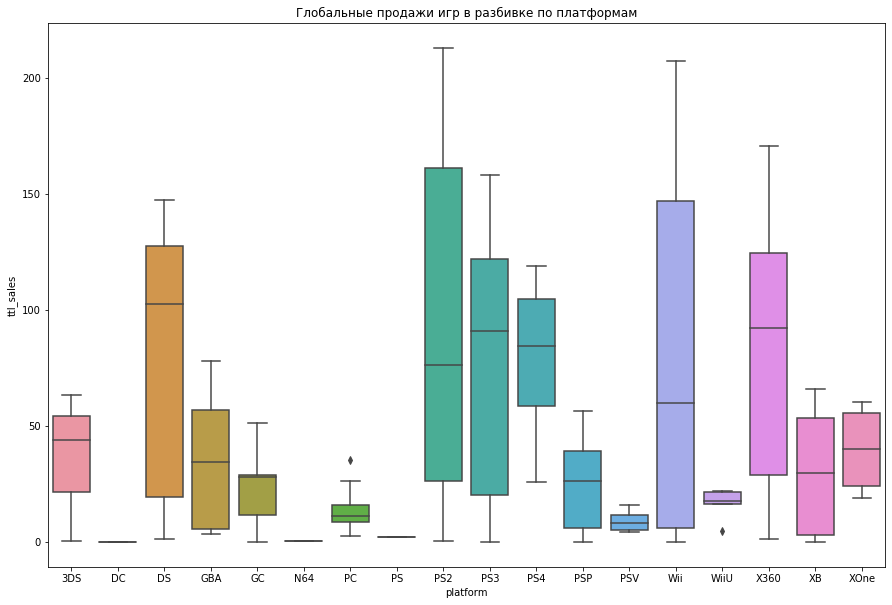

In [41]:
plt.figure(figsize=(15,10))
plt.title('Глобальные продажи игр в разбивке по платформам')
sns.boxplot(x='platform', y='ttl_sales', data=high_po)

Очевидно, что если платформы с несопоставимо маленькими продажами.  
В целом, в объёмах продаж практически нет выбросов, все они распределены довольно равномерно и пападают в разброс в 3 сигмы.

### Посмотрю, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построю диаграмму рассеяния и посчитаю корреляцию между отзывами и продажами.

Cтоит учитывать, что отзывов в выборке может быть недостаточно, чтобы делать достаточно точные выводы.

In [42]:
print('{:.1%} строк имеют оценку критиков'.format(len(df[df['critic_score'].notna()]) / len(df_new)))
print('{:.1%} строк имеют рейтинг'.format(len(df[df['rating'].notna()]) / len(df_new)))

62.5% строк имеют оценку критиков
128.3% строк имеют рейтинг


Выделю данные по топ-5 платформам

In [43]:
high_top_sales = df_new[df_new['platform'].isin(high_po_top['platform'].values)]

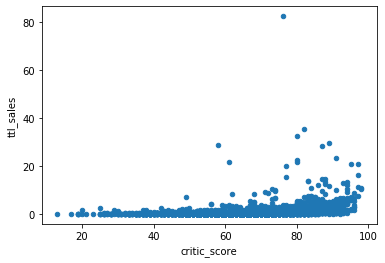

In [44]:
high_top_sales.plot(x='critic_score', y='ttl_sales', kind='scatter')

In [45]:
high_po_top['platform'].values

array(['X360', 'PS3', 'Wii', 'PS2', 'DS'], dtype=object)

In [46]:
print('Коэф. корреляции Пирсона между оценками критиков и глобальными продажами:',
    high_top_sales['ttl_sales'].corr(high_top_sales['critic_score']))

Коэф. корреляции Пирсона между оценками критиков и глобальными продажами: 0.2654165423369925


Между оценкой критиков и глобальными продажами есть слабая, но всё-таки прямая зависимоть — игры с хорошими оценками критиков продавались лучше. При этом были игры с очень хорошими оценками, но и крайне низкими продажами.

In [47]:
df_new.columns

Index(['name', 'platform', 'year', 'genre', 'na_sales', 'eu_sales', 'jp_sales',
       'other_sales', 'critic_score', 'user_score', 'rating', 'ttl_sales'],
      dtype='object')

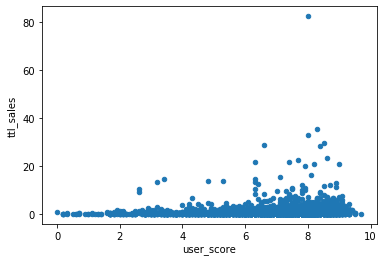

In [48]:
high_top_sales.plot(x='user_score', y='ttl_sales', kind='scatter')

In [49]:
print('Коэф. корреляции Пирсона между оценками пользователей и глобальными продажами:',
high_top_sales['ttl_sales'].corr(high_top_sales['user_score']))

Коэф. корреляции Пирсона между оценками пользователей и глобальными продажами: 0.09129211733875053


На диаграмме рассеяния можно заметить лёгкую прямую зависимость, но коэффициент корреляции Пирсона подсказывает нам, что она близка к нулю. Можно утверждать, что зависимости нет — игра могла хорошо продаваться даже при среднем невысоком рейтинге. 

### Соотнесу выводы с продажами игр на других платформах.

Выделю данные по платформам за исключением топ-5

In [50]:
not_high_top_sales = df_new[~df_new['platform'].isin(high_po_top['platform'].values)]

Построю диаграмму рассеяния

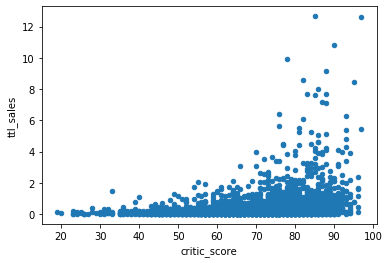

In [51]:
not_high_top_sales.plot(x='critic_score', y='ttl_sales', kind='scatter')

In [52]:
not_high_top_sales['platform'].values

array(['PS4', '3DS', '3DS', ..., 'PSV', 'GBA', 'PSV'], dtype=object)

In [53]:
not_high_top_sales = df_new[df_new['platform'].isin(not_high_top_sales['platform'].values)]

In [54]:
print('Коэф. корреляции Пирсона между оценками критиков и глобальными продажами:',
    not_high_top_sales['ttl_sales'].corr(not_high_top_sales['critic_score']))

Коэф. корреляции Пирсона между оценками критиков и глобальными продажами: 0.27206599952910476


Среди **не топ-5 платформ** между оценкой критиков и глобальными продажами есть аналогичная несильная корреляция.

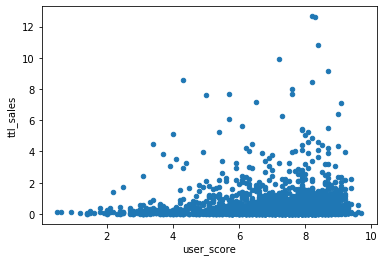

In [55]:
not_high_top_sales.plot(x='user_score', y='ttl_sales', kind='scatter')

In [56]:
print('Коэф. корреляции Пирсона между оценками пользователей и глобальными продажами:',
not_high_top_sales['ttl_sales'].corr(not_high_top_sales['user_score']))

Коэф. корреляции Пирсона между оценками пользователей и глобальными продажами: 0.05571824498801956


У не топ-5 платформ на диаграмме рассеяния можно заметить немного более сильную прямую зависимость, чем у топ-5. Но коэффициент корреляции Пирсона по-прежнему допольно слабый. Есть игры с высокой оценкой, но низкими продажами.

### Посмотрю на общее распределение игр по жанрам.
* Что можно сказать о самых прибыльных жанрах?
* Выделяются ли жанры с высокими и низкими продажами?

Посмотрю на распределение кол-ва игр и продаж по жанрам, отсортирую по возрастанию глобальных продаж

In [57]:
by_genres = df_new.groupby('genre')['ttl_sales'].agg(['sum', 'count']).reset_index().sort_values(by='sum')

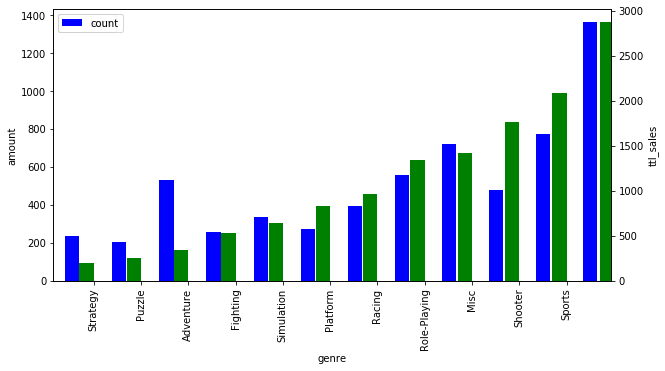

In [58]:
# !!! тут я не понял, как центровать подписи значений оси X (жанры), т.к. название жанры Action выходит за рамки графика
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
by_genres.plot(kind = 'bar', color = 'green', x = 'genre', y = 'sum', ax = ax1, position = 1, width = 0.3)
by_genres.plot(kind = 'bar', color = 'blue', x = 'genre', y = 'count', ax = ax2, position = 2, width = 0.3)
ax1.set_ylabel('amount')
ax2.set_ylabel('ttl_sales')
plt.show()

Построю график продаж по жанрам

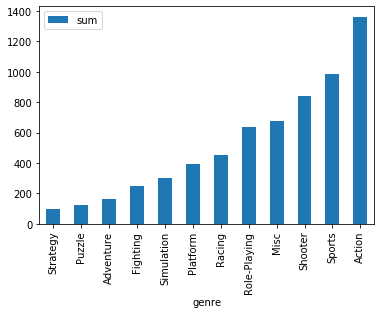

In [59]:
by_genres.plot(kind = 'bar', x = 'genre', y = 'sum')

Добавлю на график с продажами кол-во игр по жанрам

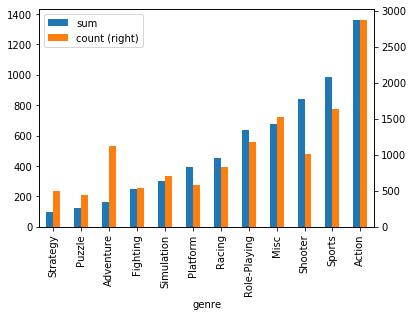

In [60]:
by_genres.plot(kind = 'bar', x = 'genre', secondary_y = 'count')

Некоторых жанры с большим количеством игра дают относительно большой объём глобальных продаж: Strategy, Adventure.  
В то время как есть жанры с большим кол-вом игр, но непропорционально меньшим объёмом продаж: Platform, Role_Playing, Shooter.  
Жанры-лидеры Sports и Action имеют большой общиё объём продаж и много игр.  

Посчитаю долю в продажах топ-3 жанра

In [61]:
print('Топ-3 жанра составляют {:.1%} общих продаж.'.format(
    by_genres['sum'].tail(3).sum() / by_genres['sum'].head(9).sum()))

Топ-3 жанра составляют 103.3% общих продаж.


Посчитаю средние глобальные продажи на каждую игру по жанрам и выведу график

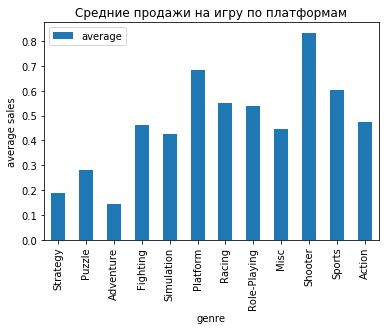

In [62]:
by_genres['average'] = by_genres['sum'] / by_genres['count']

by_genres.plot(kind = 'bar', x = 'genre', y = 'average')
plt.title('Средние продажи на игру по платформам')
plt.ylabel('average sales')
plt.show()

Наибольшие средние продажи на игру в жанрах Platform, Shooter, Role-Playing, так это очевидно.  
Но возможно на среднюю влияет небольшое кол-во очень успешных игр?

In [63]:
high_po

,platform,year,ttl_sales
0,3DS,2010,0.30
1,3DS,2011,63.20
2,3DS,2012,51.76
3,3DS,2013,56.57
4,3DS,2014,43.76
...,...,...,...
121,XB,2008,0.18
122,XOne,2013,18.96
123,XOne,2014,54.07
124,XOne,2015,60.14


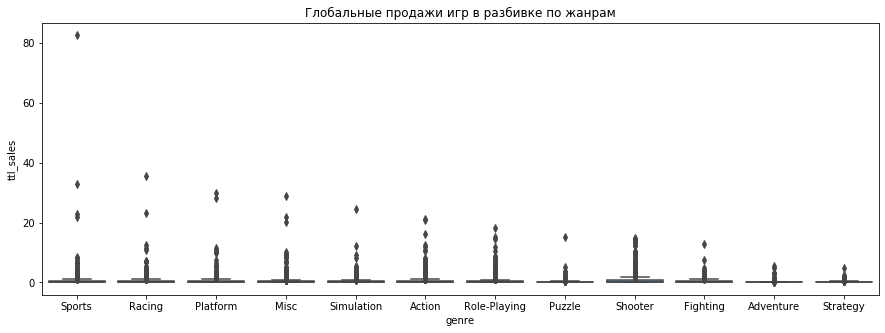

In [64]:
plt.figure(figsize=(15,5))
plt.title('Глобальные продажи игр в разбивке по жанрам')
sns.boxplot(x='genre', y='ttl_sales', data=df_new)

[(0, 1.5)]

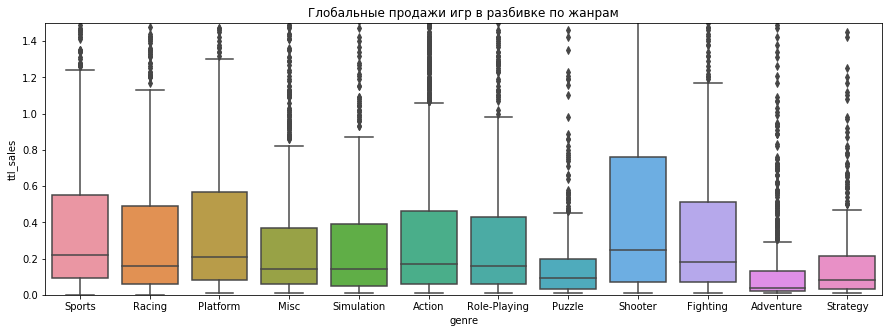

In [65]:
# посмотрю поближе
plt.figure(figsize=(15,5))
plt.title('Глобальные продажи игр в разбивке по жанрам')
sns.boxplot(x='genre', y='ttl_sales', data=df_new).set(ylim=(0, 1.5))

Похоже, что на средние продажи действительно повлияло некоторое кол-во очень успешных игра. Медиана же у разных жанров очень похожая — около 0.2 на игру.

## Шаг 4. Составлю портрет пользователя каждого региона
Определю для пользователя каждого региона (NA, EU, JP):

In [66]:
df_new.columns

Index(['name', 'platform', 'year', 'genre', 'na_sales', 'eu_sales', 'jp_sales',
       'other_sales', 'critic_score', 'user_score', 'rating', 'ttl_sales'],
      dtype='object')

### Самые популярные платформы (топ-5). Опишите различия в долях продаж.

Посмотрю на глобальный уровень

In [67]:
top_platform = df_new.groupby('platform')['ttl_sales'].sum().reset_index().sort_values(
    by = 'ttl_sales', ascending = False).reset_index(drop=True)
top_platform = top_platform.head(5)
top_platform

,platform,ttl_sales
0,X360,966.61
1,PS3,935.19
2,Wii,903.31
3,PS2,833.20
4,DS,804.26


In [68]:
sales = df_new.groupby('platform')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum().reset_index()
sales

,platform,na_sales,eu_sales,jp_sales,other_sales
0,3DS,83.11,61.46,100.62,13.32
1,DC,0.00,0.00,0.06,0.00
2,DS,381.38,188.72,175.00,59.16
3,GBA,105.42,41.76,26.89,3.90
4,GC,81.28,23.28,12.21,3.05
5,N64,0.00,0.00,0.29,0.04
6,PC,52.68,117.26,0.08,20.10
7,PS,1.15,0.78,0.00,0.14
8,PS2,386.52,207.63,89.23,149.82
9,PS3,391.60,328.97,79.52,135.10


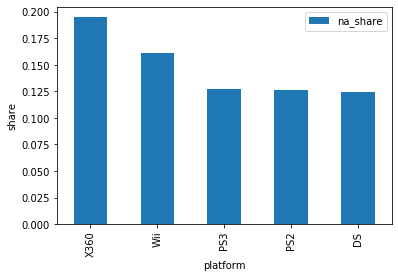

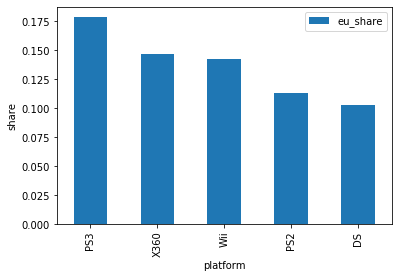

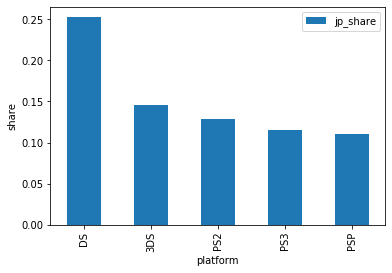

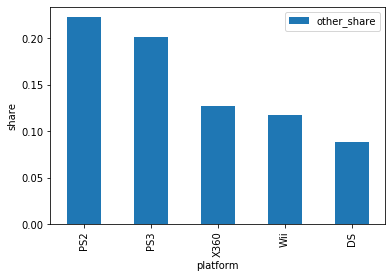

In [69]:
sales['na_share'] = sales['na_sales'] / sales['na_sales'].sum()
sales['eu_share'] = sales['eu_sales'] / sales['eu_sales'].sum()
sales['jp_share'] = sales['jp_sales'] / sales['jp_sales'].sum()
sales['other_share'] = sales['other_sales'] / sales['other_sales'].sum()
na_top = sales[['platform', 'na_share']].sort_values(
    by = 'na_share', ascending = False).head(5)
eu_top = sales[['platform', 'eu_share']].sort_values(
    by = 'eu_share', ascending = False).head(5)
jp_top = sales[['platform', 'jp_share']].sort_values(
    by = 'jp_share', ascending = False).head(5)
other_top = sales[['platform', 'other_share']].sort_values(
    by = 'other_share', ascending = False).head(5)
for reg in [na_top, eu_top, jp_top, other_top]:
    reg.plot(kind = 'bar', x = 'platform')
    plt.ylabel('share')
    plt.show()
    print()

In [70]:
# хотел автоматизировать, но не могу понять, что не так с нехешируемым списком: TypeError: unhashable type: 'list'
#for i in [['eu_sales', 'jp_sales', 'other_sales']]:
#    for j in [['eu_share', 'jp_share', 'other_share']]:
#        sales[j] = sales[i] / sales[i].sum()
#        top_na.insert(loc = 0, column = j, value = sales[['platform', j]].sort_values(by = j, ascending = False).head(5))
#na_top

Лидеры на каждом рынке занимают значительную долю от 10% до 15%. Но имеет место специфика рынка — платформы на своей родине имеют более прочные позиции, чем на "чужой территории". Например, платформы Sony занимают бОльшую долю на рынке Японии, в то время как в Северной Америке наибольшая популярность за продуктом MS.

### Самые популярные жанры (топ-5).

Сгруппирую по жанрам и суммирую глобальные продажи

In [71]:
top_genre = df_new.groupby('genre')['ttl_sales'].sum().reset_index().sort_values(
    by = 'ttl_sales', ascending = False).reset_index(drop=True)
top_genre = top_genre.head(5)
top_genre

,genre,ttl_sales
0,Action,1363.13
1,Sports,987.43
2,Shooter,838.19
3,Misc,673.70
4,Role-Playing,635.71


In [72]:
sales2 = df_new.groupby('genre')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum().reset_index()
sales2

,genre,na_sales,eu_sales,jp_sales,other_sales
0,Action,666.06,415.37,117.41,164.29
1,Adventure,72.48,42.65,31.93,13.51
2,Fighting,128.47,57.14,35.97,27.82
3,Misc,340.82,184.54,79.52,68.82
4,Platform,201.34,111.92,44.65,35.66
5,Puzzle,54.35,35.61,22.33,9.46
6,Racing,213.53,159.03,22.40,60.60
7,Role-Playing,247.29,138.01,203.21,47.20
8,Shooter,450.20,271.55,21.55,94.89
9,Simulation,145.20,96.07,34.37,26.54


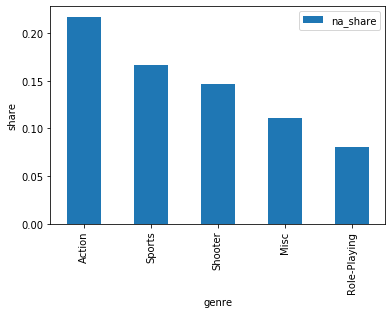

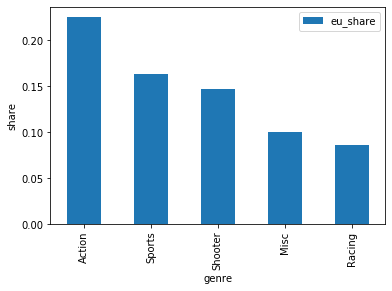

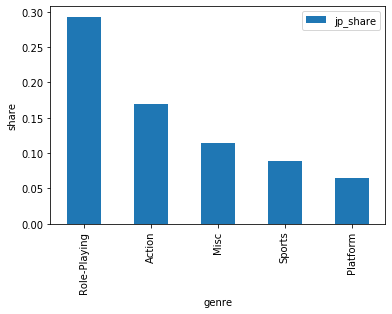

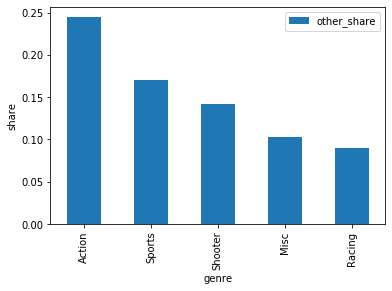

In [73]:
sales2['na_share'] = sales2['na_sales'] / sales2['na_sales'].sum()
sales2['eu_share'] = sales2['eu_sales'] / sales2['eu_sales'].sum()
sales2['jp_share'] = sales2['jp_sales'] / sales2['jp_sales'].sum()
sales2['other_share'] = sales2['other_sales'] / sales2['other_sales'].sum()
na_top = sales2[['genre', 'na_share']].sort_values(
    by = 'na_share', ascending = False).head(5)
eu_top = sales2[['genre', 'eu_share']].sort_values(
    by = 'eu_share', ascending = False).head(5)
jp_top = sales2[['genre', 'jp_share']].sort_values(
    by = 'jp_share', ascending = False).head(5)
other_top = sales2[['genre', 'other_share']].sort_values(
    by = 'other_share', ascending = False).head(5)
for reg in [na_top, eu_top, jp_top, other_top]:
    reg.plot(kind = 'bar', x = 'genre')
    plt.ylabel('share')
    plt.show()
    print()

В каждом регионе, кроме Японии лидирует жанр Action — и тут у восточного рынка своя специфика, которую придётся учитывать при принятии решений о разработке и продвижении. При этом если смотреть в целом, вкусы аудиторий в регионах очень похожи и лидируют все те же жанры: Action, Sports (более или менее), Misc.

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Посчитаю глобальные продажи в разрезе по рейтингам, кол-во игр с каждым их них, медиану и средние продажи на игру

In [74]:
esrb = df.groupby('rating')['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'ttl_sales'].agg(['median', 'mean']).reset_index()
esrb

rating na_sales           eu_sales           jp_sales            \
               median      mean   median      mean   median      mean   
0         AO    1.260  1.260000     0.61  0.610000     0.00  0.000000   
1          E    0.120  0.325817     0.03  0.179114     0.00  0.050361   
2       E10+    0.120  0.249688     0.03  0.133385     0.00  0.028470   
3         EC    0.155  0.191250     0.00  0.013750     0.00  0.000000   
4          M    0.140  0.480663     0.09  0.310920     0.00  0.040933   
5         RP    0.000  0.000000     0.02  0.020000     0.00  0.000000   
6          T    0.100  0.256403     0.04  0.144560     0.00  0.051495   
7  no_rating    0.000  0.183483     0.00  0.091118     0.02  0.125152   

  other_sales           ttl_sales            
       median      mean    median      mean  
0       0.090  0.090000     1.960  1.960000  
1       0.010  0.059025     0.200  0.614317  
2       0.020  0.052040     0.210  0.463584  
3       0.015  0.013750     0.220  0.218750  
4       0.030  0.113803     0.310  0.946319  
5       0.005  0.005000     0.025  0.025000  
6       0.020  0.052386     0.200  0.504843  
7       0.000  0.022424     0.110  0.422176

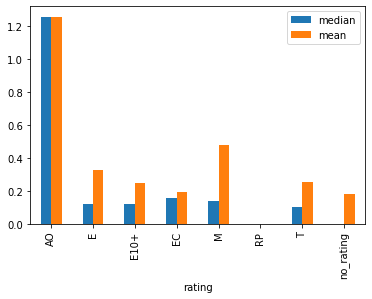

In [75]:
esrb.plot(kind = 'bar', x = 'rating', y = 'na_sales')

То же с помощью сводной таблицы

In [76]:
esrb_reg = df_new.pivot_table(
    index = 'rating', values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], aggfunc=['mean', 'median']).reset_index()
esrb_reg

rating      mean                                   median           \
              eu_sales  jp_sales  na_sales other_sales eu_sales jp_sales   
0         AO  0.610000  0.000000  1.260000    0.090000     0.61     0.00   
1          E  0.181544  0.051025  0.323883    0.063539     0.02     0.00   
2       E10+  0.133466  0.028490  0.249865    0.052069     0.03     0.00   
3         EC  0.013750  0.000000  0.191250    0.013750     0.00     0.00   
4          M  0.307617  0.035477  0.468502    0.115456     0.09     0.00   
5         RP  0.020000  0.000000  0.000000    0.005000     0.02     0.00   
6          T  0.131234  0.043139  0.238674    0.053051     0.04     0.00   
7  no_rating  0.068101  0.076306  0.091073    0.021579     0.00     0.02   

                        
  na_sales other_sales  
0    1.260       0.090  
1    0.120       0.010  
2    0.120       0.020  
3    0.155       0.015  
4    0.140       0.030  
5    0.000       0.005  
6    0.100       0.020  
7    0.000       0.000

Добавлю столбец, по которому и сделаю сортировку по возрастанию возрастного ценза

In [77]:
esrb_reg['sort'] = [6, 2, 3, 1, 5, 7, 4, 8]
esrb_reg = esrb_reg.sort_values(by = 'sort')
esrb_reg

rating      mean                                   median           \
              eu_sales  jp_sales  na_sales other_sales eu_sales jp_sales   
3         EC  0.013750  0.000000  0.191250    0.013750     0.00     0.00   
1          E  0.181544  0.051025  0.323883    0.063539     0.02     0.00   
2       E10+  0.133466  0.028490  0.249865    0.052069     0.03     0.00   
6          T  0.131234  0.043139  0.238674    0.053051     0.04     0.00   
4          M  0.307617  0.035477  0.468502    0.115456     0.09     0.00   
0         AO  0.610000  0.000000  1.260000    0.090000     0.61     0.00   
5         RP  0.020000  0.000000  0.000000    0.005000     0.02     0.00   
7  no_rating  0.068101  0.076306  0.091073    0.021579     0.00     0.02   

                       sort  
  na_sales other_sales       
3    0.155       0.015    1  
1    0.120       0.010    2  
2    0.120       0.020    3  
6    0.100       0.020    4  
4    0.140       0.030    5  
0    1.260       0.090    6  
5    0.000       0.005    7  
7    0.000       0.000    8

Построю диаграммы среднего и медианы объёмов продаж

Text(0.5, 1.0, 'Медианные продажи игр в разных регионах по рейтингам')

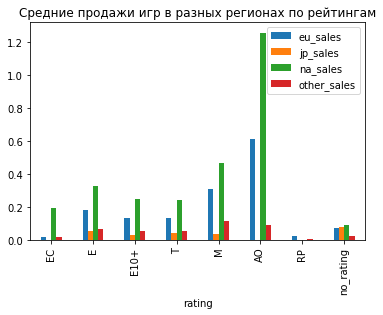

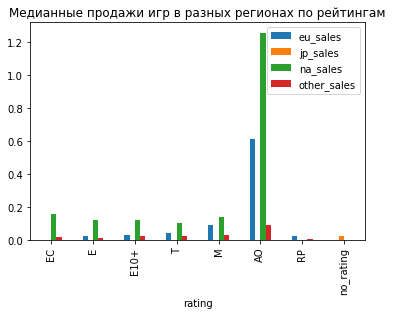

In [78]:
esrb_reg.plot(kind = 'bar', x = 'rating', y = 'mean')
plt.title('Средние продажи игр в разных регионах по рейтингам')
esrb_reg.plot(kind = 'bar', x = 'rating', y = 'median')
plt.title('Медианные продажи игр в разных регионах по рейтингам')

Походе, что в Северной Америке и Европе большой популярностью полльзуются жанры "Для взрослых 17+" и "Только для взрослых 18+".  
В то время как в Японии одинаково популярны игры с менее жесткими возрастными ограничениями: от Е до М. А вот АО совсем не пользуется спросом.  
В других регионах картина компромиссная между предыдущими двумя.

In [79]:
esrb_reg = df_new.pivot_table(
    index = 'rating', values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], aggfunc=('mean', 'median')).reset_index()
esrb_reg

rating  eu_sales         jp_sales         na_sales        other_sales  \
                  mean median      mean median      mean median        mean   
0         AO  0.610000   0.61  0.000000   0.00  1.260000  1.260    0.090000   
1          E  0.181544   0.02  0.051025   0.00  0.323883  0.120    0.063539   
2       E10+  0.133466   0.03  0.028490   0.00  0.249865  0.120    0.052069   
3         EC  0.013750   0.00  0.000000   0.00  0.191250  0.155    0.013750   
4          M  0.307617   0.09  0.035477   0.00  0.468502  0.140    0.115456   
5         RP  0.020000   0.02  0.000000   0.00  0.000000  0.000    0.005000   
6          T  0.131234   0.04  0.043139   0.00  0.238674  0.100    0.053051   
7  no_rating  0.068101   0.00  0.076306   0.02  0.091073  0.000    0.021579   

          
  median  
0  0.090  
1  0.010  
2  0.020  
3  0.015  
4  0.030  
5  0.005  
6  0.020  
7  0.000

na_sales


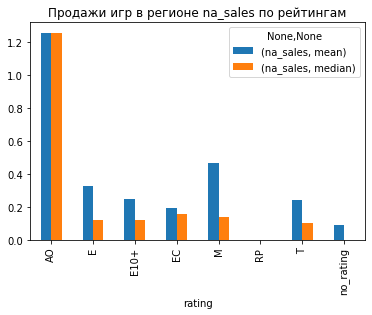


eu_sales


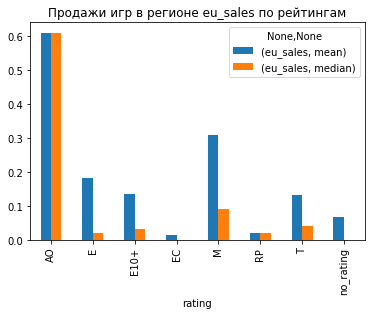


jp_sales


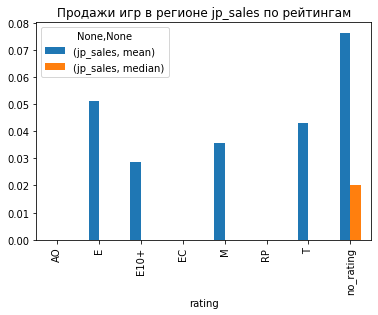


other_sales


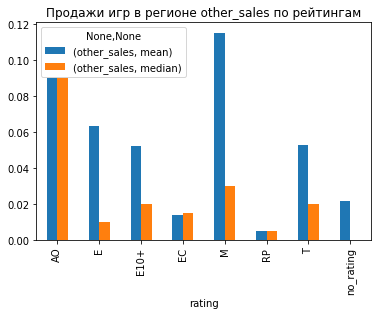

In [80]:
for reg in ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']:
    print(reg)
    esrb_reg[['rating', reg]].plot(kind = 'bar', x = 'rating')
    plt.title('Продажи игр в регионе {} по рейтингам'.format(reg))
    plt.show()
    print()

Итоговые потреты пользователей каждого региона.

**NA**

    Пользователи региона NA (Северная Америка) для игр используют в основном Xbox 360 отечественного производства или японских производителей Nintendo или Sony. Здесь в почёте динамичные жанры с быстрым геймплеем — Action, Sport, Shooter. Пользователи пробуют много игр.
    
**EU**

    Пользователи европейского региона по жанровым вкусам и распределению возрастных рейтингов очень похоже на американских с менее выраженными крайними значениями. По всем показателям здесь «более средние» потребители.
    
**JP**
    
    А вот где отличились, так это на Японском рынке. Здесь пользователи во многом ведут себя особенным образом в своём большинстве. Здесь во главе угла отечественные производители платформ, которые при том могут обеспечить для пользователей достаточное разнообразие и комфортный гейминг в разных поколениях устройств и форматах — DS, 3DS, PS2, PS3, PS4. Пользователи предпочитают и неспешные ролевые игры и игры разнообразных жанров, без чёткой классификации, но так же много времени готовы уделять популярным на Западе жанрам Action и Sports. Большинство игр сделать продаётся без рейтинга, а среди рейтинговых совсем не пользуются спросом игры «только для взрослых».

## Шаг 5. Проверю гипотезы

Пороговое значение aplpha установлю 5% как общепринятый вариант.

In [81]:
alpha = 0.05

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

In [82]:
df_new['platform'].unique()

array(['Wii', 'DS', 'X360', 'PS3', 'PS2', 'PS4', '3DS', 'GBA', 'XB', 'PC',
       'PSP', 'XOne', 'WiiU', 'GC', 'PSV', 'PS', 'N64', 'DC'],
      dtype=object)

Верну 2 массива с пользовательским рейтингом для каждой из платформ

In [83]:
xone = df_new[df_new['platform'] == 'XOne']
pc = df_new[df_new['platform'] == 'PC']
xone.dropna(subset=['user_score'], inplace=True)
pc.dropna(subset=['user_score'], inplace=True)

In [84]:
xone = xone['user_score'].to_list()
pc = pc['user_score'].to_list()

Сформулирую **нулевую гипотезу**:  
Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
**Ненулевая гипотеза** будет звучать так: средние пользовательские рейтинги платформ Xbox One и PC разные.

In [85]:
result_platform = st.ttest_ind(xone, pc)
print('p-значение: ', result_platform.pvalue)
if result_platform.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  0.000258622536601814
Отвергаем нулевую гипотезу


Пришлось отвергнуть нулевую гипотезу, скорее всего пользовательские рейтинги отличаются у этих двух платформ.

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

In [86]:
df_new['genre'].unique()

array(['Sports', 'Racing', 'Platform', 'Misc', 'Simulation', 'Action',
       'Role-Playing', 'Puzzle', 'Shooter', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

Верну 2 массива с пользовательским рейтингом для каждого из жанров

In [87]:
action = df_new[df_new['genre'] == 'Action']
sports = df_new[df_new['genre'] == 'Sports']
action.dropna(subset=['user_score'], inplace=True)
sports.dropna(subset=['user_score'], inplace=True)

In [88]:
action = action['user_score'].to_list()
sports = sports['user_score'].to_list()

Сформулирую **нулевую гипотезу**:  
средние пользовательские рейтинги жанров Action и Sports одинаковые.
**Ненулевая гипотеза** будет звучать так: средние пользовательские рейтинги жанров Action и Sports разные.

In [89]:
result_genre = st.ttest_ind(action, sports)
print('p-значение: ', result_genre.pvalue)
if result_genre.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  0.0010957701777769982
Отвергаем нулевую гипотезу


Похоже, что средние пользовательские рейтинги этих платформ отличаются.

## Шаг 6. Общий вывод

У пользователей в разных регионах вкусы отличаются. Но очевидно, что есть как очень успешные платформы (PS2, PS3, Xbox360, NintendoDS, NintendoWii), так и малопопулярные. Имеет место специфика региона, так платформы более сильны на своей родине.
Оценки пользователей не корректируют с успешностью игр, а вот критики более объективны в своих оценках.  
3 наиболее популярных жанра — Shooter, Sports, Action — приносят 90% оборота глобального рынка игр. При этом отличается популярность по возрастным рейтингам — в Азии не любят игры только для взрослых и для совсем маленьких.